# Machine Learning Subte

El objetivo de esta notebook es generar un modelo de machine learning que pueda predecir la cantidad de viajes dado: Linea,Estacion,tarifa,mes y dia de la semana. Se evaluaran distintos modelos de ML a fines de escojer el mejor

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
MAX_ROWS = 10
pd.set_option('display.max_rows', MAX_ROWS)
pd.set_option('display.max_columns', 200)
 
sns.set_style("whitegrid")
sns.set_context("paper")

%matplotlib inline

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


Funciones para utilizar durante toda la notebook

In [3]:
def params_gs(df,target,alg,grid,cv=5):#gridsearch cv para buscar hyperparametros
    X = df.drop(target,axis=1)
    y = df[target]
    grid = GridSearchCV(alg,param_grid=grid,cv=cv,scoring='neg_mean_squared_error',verbose=10)
    grid.fit(X,y)
    print(grid.best_score_)
    print(grid.best_params_)
    return grid.best_estimator_

In [4]:
def transform_df(df):#transforma el dataframe para ingresar al modelo utilizando variables dummies
    df = df.join(pd.get_dummies(df['ESTACION']))
    df = df.join(pd.get_dummies(df['turno']))
    df = df.drop(['LINEA','ESTACION','year','turno'],axis=1)
    return df

In [5]:
def validate_model(df,target,models):#evalua una serie de modelos aplicandoles crossvalidation
    names = []
    results = []
    X = df.drop(target,axis=1)
    y = df[target]
    for name,model in models:
        kvfold = KFold(n_splits=10,random_state=21)
        cvresults = cross_val_score(model,X,y,cv=kvfold,scoring='neg_mean_squared_error')
        results.append(cvresults)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cvresults.mean(), cvresults.std())
        print(msg)

In [6]:
def test_pred(df,target,model):#predice el Test-set  y construye un dataframe con los resultados obtenidos 
    X = df.drop(target,axis=1)
    y = df[target]
    y_pred = model.predict(X)
    print(mean_squared_error(y,y_pred))
    return pd.DataFrame({'Real':y,'Modelo':y_pred,'Diferencia':y-y_pred})

In [7]:
df = pd.read_csv(r'...\Subte\datafinal.csv')

In [8]:
df['TOTAL'].describe().apply(lambda x: format(x, 'f'))

count    12025078.000000
mean          148.094779
std           215.142196
min             0.000000
25%            30.000000
50%            81.000000
75%           196.000000
max         15328.000000
Name: TOTAL, dtype: object

Si bien realizamos transformaciones al datset en las notebooks pasadas la variable 'TOTAL' solamente fue evaluada en forma descriptiva. A fines de utilizarla en un modelo es importante evaluar la distribucion de la misma. Podemos observar que hay una serie de outliers los cuales filtraremos para solamente trabajar con un poco mas del percentil 75

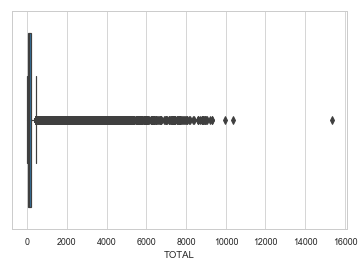

In [9]:
sns.boxplot(x=df['TOTAL'])

In [10]:
df_filtered=df.drop(df.index[df['TOTAL']>=200])

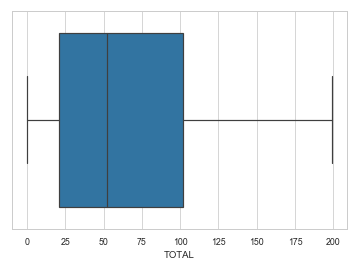

In [11]:
sns.boxplot(x=df_filtered['TOTAL'])

Entrenaremos el modelo utilizando los datos del 2018 y 2019 para tener una predicion mas acorde a la actualidad. El enfoque que utilizaremos es generar 1 modelo por cada linea.

In [12]:
traintest=df_filtered.loc[(df_filtered['year']==2018)|(df_filtered['year']==2019)]
traintest = traintest.sample(traintest.shape[0])
A = traintest[traintest['LINEA']=='A']
train_A,test_A = train_test_split(A,random_state=21,test_size=0.10)



# Linea A

In [13]:
train_A=transform_df(train_A).reset_index(drop=True)
test_A=transform_df(test_A).reset_index(drop=True)

In [14]:
#train_A=train_A.drop(train_A.index[train_A['TOTAL']==0])

Evaluaremos los siguientes modelos con la funcion Validate model que declaramos previamente

In [15]:
models = []
models.append(('LR',LinearRegression()))
models.append(('LS',Lasso()))
models.append(('DT',DecisionTreeRegressor()))
models.append(('GB',GradientBoostingRegressor(n_estimators=200)))

In [16]:
validate_model(train_A,'TOTAL',models)

LR: -1965.697403 (6.166650)
LS: -2127.196482 (8.268043)
DT: -1197.539934 (7.041030)
GB: -1407.012571 (5.604641)


DT y GB tuvieron los mejores scores buscaremos sus mejores hyper-parametros y evaluaremos su performance contra el set de Test

In [17]:
DT = DecisionTreeRegressor()

In [18]:
GB = GradientBoostingRegressor()

In [19]:
param_gridDT = {'max_depth':[None,10,20,30]}

In [20]:
param_gridGB={'n_estimators':[100,200,250]}

In [21]:
DTop = params_gs(train_A,'TOTAL',DT,grid=param_gridDT)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] max_depth=None ..................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ......... max_depth=None, score=-1197.319500461795, total=   1.5s
[CV] max_depth=None ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV] ........ max_depth=None, score=-1203.3741171659344, total=   1.5s
[CV] max_depth=None ..................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.5s remaining:    0.0s


[CV] ........ max_depth=None, score=-1205.7126295272064, total=   1.5s
[CV] max_depth=None ..................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.3s remaining:    0.0s


[CV] ........ max_depth=None, score=-1210.2692355350528, total=   1.5s
[CV] max_depth=None ..................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.1s remaining:    0.0s


[CV] ........ max_depth=None, score=-1194.5175164627199, total=   1.5s
[CV] max_depth=10 ....................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.0s remaining:    0.0s


[CV] .......... max_depth=10, score=-1451.3228757161633, total=   1.0s
[CV] max_depth=10 ....................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   10.2s remaining:    0.0s


[CV] .......... max_depth=10, score=-1447.2641127508537, total=   1.0s
[CV] max_depth=10 ....................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   11.5s remaining:    0.0s


[CV] ........... max_depth=10, score=-1449.205637731165, total=   1.0s
[CV] max_depth=10 ....................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   12.7s remaining:    0.0s


[CV] ........... max_depth=10, score=-1451.121523578674, total=   1.0s
[CV] max_depth=10 ....................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   14.0s remaining:    0.0s


[CV] .......... max_depth=10, score=-1438.7162315153168, total=   1.0s
[CV] max_depth=20 ....................................................
[CV] .......... max_depth=20, score=-1227.3063550973463, total=   1.4s
[CV] max_depth=20 ....................................................
[CV] .......... max_depth=20, score=-1225.7979221388289, total=   1.5s
[CV] max_depth=20 ....................................................
[CV] .......... max_depth=20, score=-1233.8909038810639, total=   1.4s
[CV] max_depth=20 ....................................................
[CV] .......... max_depth=20, score=-1237.3960827523465, total=   1.4s
[CV] max_depth=20 ....................................................
[CV] .......... max_depth=20, score=-1219.4712089338466, total=   1.4s
[CV] max_depth=30 ....................................................
[CV] .......... max_depth=30, score=-1197.6172369342062, total=   1.5s
[CV] max_depth=30 ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   32.8s finished


-1202.2385924828104
{'max_depth': None}


In [22]:
GBop = params_gs(train_A,'TOTAL',GB,grid=param_gridGB)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...... n_estimators=100, score=-1487.0093440823368, total=  38.4s
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   39.2s remaining:    0.0s


[CV] ...... n_estimators=100, score=-1483.5897737514956, total=  39.6s
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s


[CV] ....... n_estimators=100, score=-1488.583945085661, total=  38.9s
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.0min remaining:    0.0s


[CV] ...... n_estimators=100, score=-1486.4464905525583, total=  38.4s
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.6min remaining:    0.0s


[CV] ....... n_estimators=100, score=-1476.832617499106, total=  39.2s
[CV] n_estimators=200 ................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.3min remaining:    0.0s


[CV] ...... n_estimators=200, score=-1414.4025804092078, total= 1.2min
[CV] n_estimators=200 ................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  4.6min remaining:    0.0s


[CV] ...... n_estimators=200, score=-1406.3494219513136, total= 1.2min
[CV] n_estimators=200 ................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  5.8min remaining:    0.0s


[CV] ...... n_estimators=200, score=-1412.1992966334894, total= 1.2min
[CV] n_estimators=200 ................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  7.1min remaining:    0.0s


[CV] ...... n_estimators=200, score=-1410.8208802057256, total= 1.2min
[CV] n_estimators=200 ................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  8.4min remaining:    0.0s


[CV] ...... n_estimators=200, score=-1399.3671958083823, total= 1.2min
[CV] n_estimators=250 ................................................
[CV] ...... n_estimators=250, score=-1398.7491079688677, total= 1.5min
[CV] n_estimators=250 ................................................
[CV] ...... n_estimators=250, score=-1388.9482407838825, total= 1.5min
[CV] n_estimators=250 ................................................
[CV] ...... n_estimators=250, score=-1394.6253108770645, total= 1.5min
[CV] n_estimators=250 ................................................
[CV] ...... n_estimators=250, score=-1393.1095816262903, total= 1.5min
[CV] n_estimators=250 ................................................
[CV] ...... n_estimators=250, score=-1381.8615536827829, total= 1.5min


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 17.3min finished


-1391.4587682702281
{'n_estimators': 250}


In [23]:
resultsGB = test_pred(test_A,'TOTAL',GBop)
resultsDT = test_pred(test_A,'TOTAL',DTop)

1384.2550733381793
1190.8165490712909


Determinamos que el Decision Tree es el mejor modelo para la linea A

In [24]:
pickle_a = open('modeloA.pickle','wb')
pickle.dump(DTop,pickle_a)
pickle_a.close()


Evaluacion y diferencia entre el modelo y lo real

In [25]:
resultsDT

,Real,Modelo,Diferencia
0,60.0,63.092593,-3.092593
1,113.0,112.555556,0.444444
2,3.0,10.444444,-7.444444
3,121.0,102.344262,18.655738
4,49.0,62.630769,-13.630769
...,...,...,...
57210,13.0,73.181818,-60.181818
57211,166.0,162.479167,3.520833
57212,72.0,63.511364,8.488636
57213,164.0,66.230769,97.769231


# Deep Learning

Aplicaremos una red neuronal al mismo problema 

In [26]:
from keras import Sequential
from keras.layers import Activation,Dense

Using TensorFlow backend.


In [27]:
X = train_A.drop('TOTAL',axis=1)
y = train_A['TOTAL']


In [31]:
model = Sequential()

In [32]:
model.add(Dense(128,input_dim=26,activation='relu'))

model.add(Dense(256,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(256,activation='relu'))

model.add(Dense(1,activation='linear'))

model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mean_squared_error'])


In [33]:
model.fit(X,y,validation_split=0.1,epochs=10)

Train on 463438 samples, validate on 51494 samples
Epoch 1/10
463438/463438 [==============================] - 27s 59us/step - loss: 1471.9001 - mean_squared_error: 1471.9001 - val_loss: 1349.3000 - val_mean_squared_error: 1349.3000
Epoch 2/10
463438/463438 [==============================] - 27s 58us/step - loss: 1337.6238 - mean_squared_error: 1337.6238 - val_loss: 1319.6295 - val_mean_squared_error: 1319.6295
Epoch 3/10
463438/463438 [==============================] - 25s 55us/step - loss: 1310.0854 - mean_squared_error: 1310.0854 - val_loss: 1292.6942 - val_mean_squared_error: 1292.6942
Epoch 4/10
463438/463438 [==============================] - 27s 58us/step - loss: 1294.2117 - mean_squared_error: 1294.2117 - val_loss: 1288.5086 - val_mean_squared_error: 1288.5086
Epoch 5/10
463438/463438 [==============================] - 27s 58us/step - loss: 1281.2303 - mean_squared_error: 1281.2303 - val_loss: 1266.6618 - val_mean_squared_error: 1266.6618
Epoch 6/10
463438/463438 [=============

In [34]:
X = test_A.drop('TOTAL',axis=1)
y = test_A['TOTAL']

In [35]:
y_pred = model.predict(X)

In [36]:
print(mean_squared_error(y,y_pred))

1251.0215976990153


In [48]:
resultsDL =pd.DataFrame(y_pred).join(y)

In [53]:
resultsDL.rename(columns={0:'Modelo','TOTAL':'Real'},inplace=True)

In [54]:
resultsDL['dif'] = resultsDL['Real']-resultsDL['Modelo']

In [55]:
resultsDL.head()

,Modelo,Real,dif
0,71.772865,60.0,-11.772865
1,113.921402,113.0,-0.921402
2,12.480394,3.0,-9.480394
3,113.669640,121.0,7.330360
4,66.986938,49.0,-17.986938
